In [50]:
## analyse the data
import mne
import numpy as np
import matplotlib.pyplot as plt

# Loading all subjects data and converting into numpy array

In [233]:
def read_data(path):
    raw=mne.io.read_raw_gdf(path,preload=True)
    raw.set_eeg_reference()
    events=mne.events_from_annotations(raw)
    epochs = mne.Epochs(raw, events[0], event_id=[3,6],tmin= 2, tmax=3, baseline=(None,3),on_missing ='warn')
    labels=epochs.events[:,-1]
    features=epochs.get_data()
    return features,labels

In [234]:
%%capture
features,labels,groups=[],[],[]
for i in range(1,4):
    feature,label=read_data(f'IIIa gdf format/subject{i}.gdf')
    features.append(feature)
    labels.append(label)
    groups.append([i]*len(label))

In [235]:
features=np.concatenate(features)
labels=np.concatenate(labels)
groups=np.concatenate(groups)

features.shape,labels.shape,groups.shape

((210, 60, 251), (210,), (210,))

In [236]:
unique, counts = np.unique(labels, return_counts=True)
unique, counts

(array([3, 6]), array([105, 105], dtype=int64))

In [237]:
unique, counts = np.unique(groups, return_counts=True)
unique, counts

(array([1, 2, 3]), array([90, 60, 60], dtype=int64))

# Tensorflow pre processing

In [238]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn import preprocessing

In [248]:
lb = preprocessing.LabelBinarizer()

#enc_df= enc.fit_transform(dataset['60'])
enc_labels =  lb.fit_transform(labels)

In [274]:
X_train, X_test, Y_train, Y_test = train_test_split(features, enc_labels, test_size=0.2, random_state=42)

In [275]:
X_train.shape , Y_train.shape,X_test.shape, Y_test.shape

((168, 60, 251), (168, 1), (42, 60, 251), (42, 1))

In [276]:
x_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(Y_train)
x_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(Y_test)

In [277]:
x_train.shape , y_train.shape,x_test.shape, y_test.shape

(TensorShape([168, 60, 251]),
 TensorShape([168, 1]),
 TensorShape([42, 60, 251]),
 TensorShape([42, 1]))

In [278]:
from EEGModels import *

# EEGNet

In [279]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta

    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('sigmoid', name = 'sigmoid')(dense)
    
    return Model(inputs=input1, outputs=softmax)


In [280]:
eegnet = EEGNet(1, features.shape[1],features.shape[2],dropoutRate = 0.5)
eegnet.summary()

Model: "functional_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 60, 251, 1)]      0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 60, 251, 8)        512       
_________________________________________________________________
batch_normalization_80 (Batc (None, 60, 251, 8)        32        
_________________________________________________________________
depthwise_conv2d_22 (Depthwi (None, 1, 251, 16)        960       
_________________________________________________________________
batch_normalization_81 (Batc (None, 1, 251, 16)        64        
_________________________________________________________________
activation_65 (Activation)   (None, 1, 251, 16)        0         
_________________________________________________________________
average_pooling2d_46 (Averag (None, 1, 62, 16)       

In [281]:
eegnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss = tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [282]:
eegnet_history = eegnet.fit(x_train, y_train,epochs=50,batch_size=5,validation_data=(x_test, y_test))

Epoch 1/50
34/34 [==============================] - 2s 56ms/step - loss: 0.6935 - accuracy: 0.4405 - val_loss: 0.6932 - val_accuracy: 0.4762
Epoch 2/50
34/34 [==============================] - 2s 50ms/step - loss: 0.6936 - accuracy: 0.4464 - val_loss: 0.6932 - val_accuracy: 0.4762
Epoch 3/50
34/34 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.46 - 2s 52ms/step - loss: 0.6933 - accuracy: 0.4583 - val_loss: 0.6933 - val_accuracy: 0.4762
Epoch 4/50
34/34 [==============================] - 2s 55ms/step - loss: 0.6932 - accuracy: 0.4762 - val_loss: 0.6933 - val_accuracy: 0.4762
Epoch 5/50
34/34 [==============================] - 2s 55ms/step - loss: 0.6927 - accuracy: 0.5417 - val_loss: 0.6936 - val_accuracy: 0.4762
Epoch 6/50
34/34 [==============================] - 2s 56ms/step - loss: 0.6912 - accuracy: 0.5476 - val_loss: 0.6939 - val_accuracy: 0.4762
Epoch 7/50
34/34 [==============================] - 2s 61ms/step - loss: 0.6883 - accuracy: 0.5536 - val_loss: 0

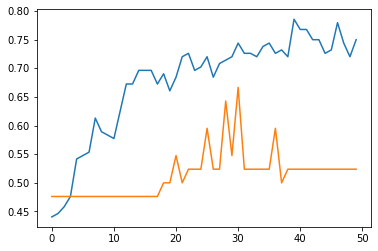

In [283]:
plt.plot(eegnet_history.history["accuracy"])
plt.plot(eegnet_history.history["val_accuracy"])

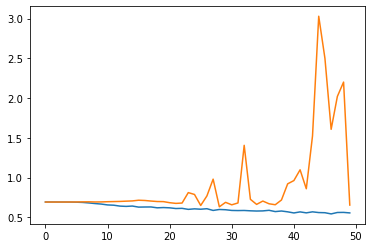

In [284]:
plt.plot(eegnet_history.history["loss"])
plt.plot(eegnet_history.history["val_loss"])

# DeepConvNet

In [212]:
deepconvnet = DeepConvNet(4, features.shape[1],features.shape[2],dropoutRate = 0.5)
deepconvnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),loss = tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
deepconvnet.summary()

Model: "functional_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 60, 251, 1)]      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 60, 247, 25)       150       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 1, 247, 25)        37525     
_________________________________________________________________
batch_normalization_56 (Batc (None, 1, 247, 25)        100       
_________________________________________________________________
activation_42 (Activation)   (None, 1, 247, 25)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 123, 25)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 1, 123, 25)      

In [221]:
deepconvnet_history = deepconvnet.fit(x_train, y_train,epochs=15,batch_size=2,validation_data=(x_test, y_test))

Epoch 1/15
189/189 [==============================] - 3s 18ms/step - loss: 1.4435 - accuracy: 0.2725 - val_loss: 63.3956 - val_accuracy: 0.2619
Epoch 2/15
189/189 [==============================] - 3s 17ms/step - loss: 1.4437 - accuracy: 0.2540 - val_loss: 5.6598 - val_accuracy: 0.1667
Epoch 3/15
189/189 [==============================] - 3s 18ms/step - loss: 1.4291 - accuracy: 0.2460 - val_loss: 6.6240 - val_accuracy: 0.3810
Epoch 4/15
189/189 [==============================] - 3s 18ms/step - loss: 1.4421 - accuracy: 0.2646 - val_loss: 1.3567 - val_accuracy: 0.3810
Epoch 5/15
189/189 [==============================] - 4s 19ms/step - loss: 1.4390 - accuracy: 0.2487 - val_loss: 5.9558 - val_accuracy: 0.2619
Epoch 6/15
189/189 [==============================] - 4s 19ms/step - loss: 1.4366 - accuracy: 0.2407 - val_loss: 1.4655 - val_accuracy: 0.2381
Epoch 7/15
189/189 [==============================] - 4s 19ms/step - loss: 1.4367 - accuracy: 0.2487 - val_loss: 1.8789 - val_accuracy: 0.381

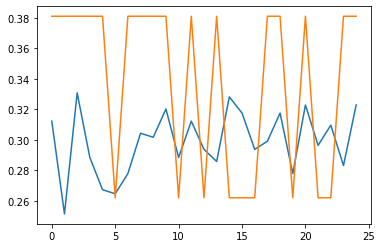

In [220]:
plt.plot(deepconvnet_history.history["accuracy"])
plt.plot(deepconvnet_history.history["val_accuracy"])

In [224]:
sconvnet = ShallowConvNet(4, features.shape[1],features.shape[2],dropoutRate = 0.2)
sconvnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss = tf.keras.losses.CategoricalCrossentropy(),
                 metrics=['accuracy'])
sconvnet.summary()

Model: "functional_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 60, 251, 1)]      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 60, 239, 40)       560       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 1, 239, 40)        96000     
_________________________________________________________________
batch_normalization_61 (Batc (None, 1, 239, 40)        160       
_________________________________________________________________
activation_50 (Activation)   (None, 1, 239, 40)        0         
_________________________________________________________________
average_pooling2d_33 (Averag (None, 1, 30, 40)         0         
_________________________________________________________________
activation_51 (Activation)   (None, 1, 30, 40)       

In [225]:
deepconvnet_history = deepconvnet.fit(x_train, y_train,epochs=15,batch_size=2,validation_data=(x_test, y_test))

Epoch 1/15
189/189 [==============================] - 3s 18ms/step - loss: 1.4369 - accuracy: 0.2143 - val_loss: 1.3730 - val_accuracy: 0.3810
Epoch 2/15
189/189 [==============================] - 4s 20ms/step - loss: 1.4233 - accuracy: 0.2619 - val_loss: 1.9438 - val_accuracy: 0.2619
Epoch 3/15
189/189 [==============================] - 5s 25ms/step - loss: 1.4184 - accuracy: 0.2698 - val_loss: 1.5019 - val_accuracy: 0.1667
Epoch 4/15
189/189 [==============================] - 4s 22ms/step - loss: 1.4269 - accuracy: 0.2381 - val_loss: 5.6637 - val_accuracy: 0.1667
Epoch 5/15
189/189 [==============================] - 4s 23ms/step - loss: 1.4174 - accuracy: 0.2751 - val_loss: 2.3192 - val_accuracy: 0.1667
Epoch 6/15
189/189 [==============================] - 4s 22ms/step - loss: 1.4377 - accuracy: 0.2275 - val_loss: 1.4799 - val_accuracy: 0.1667
Epoch 7/15
189/189 [==============================] - 4s 23ms/step - loss: 1.4472 - accuracy: 0.2566 - val_loss: 1.6269 - val_accuracy: 0.1667